# 1-02 Check preprocessed data with results

- This notebook includes ipywidgets to check plots generated from the previous notebook (`1-02_postprocessing.ipynb`)

2021-03-02

In [1]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *

rand_seed = 0

## Settings

In [13]:
use_mel = True

# --- data param
vowel_target_file = 'vowel_targets.csv'
grand_mean_file = 'grand_means.csv'
pca_regular_file = 'pca_regular.pkl'
pca_guided_file = 'pca_guided.pkl'
pca_file = 'pca.pkl'
zscore_file = 'zscore.pkl'
stat_file = 'data_stat.csv'

data_dir = 'data'
plot_dir = 'data_plots'
data_processed = 'data_processed'

# --- hyperparam
rate_list = ['N', 'F']
acous_col = ['F1', 'F2']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
num_points = 5
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
const_list = ['P','B','T','D','S','K','G','HH']
poa_list = ['bilabial','alveolar','velar','fricative']

In [17]:
# Load raw data
D = pd.read_csv(os.path.join(data_processed, stat_file))
D.drop(D.columns[0], axis=1, inplace=True);
print(D.shape)

(138575, 56)


In [19]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
# vowel_list = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UH1", "UW1"]
vowel_list = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"]
D = D.loc[D.Vowel.isin(vowel_list)].reset_index(drop=True)
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print("Speaker:", spkr_list)
print("Words: num=", len(word_list))
print("Vowels (all):", vowel_list_all)
print("Vowels (selected):", vowel_list)  # 9 vowels selected
print("Blocks:", block_list)
print('Times:', time_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Words: num= 1051
Vowels (all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'AH1', 'AO1', 'UW1']
Blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Times: [0.0, 0.25, 0.5, 0.75, 1.0]


In [40]:
# Load parameters
with open(os.path.join(data_processed, zscore_file), 'rb') as pckl:
    Z = pickle.load(pckl)
with open(os.path.join(data_processed, pca_file), 'rb') as pckl:
    PC = pickle.load(pckl)    

In [10]:
# Load palate
pal_files = sorted(glob(os.path.join(data_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


## Vowel duration by speaker and vowel

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

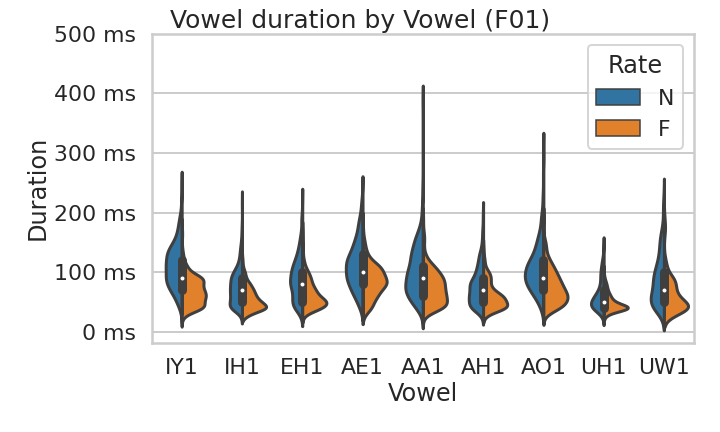

In [21]:
# Check duration plots
def func1(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_duration.png'), width=500)

interact(func1, which_spkr=spkr_list);
func('F01')

## Normalized vowel space

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

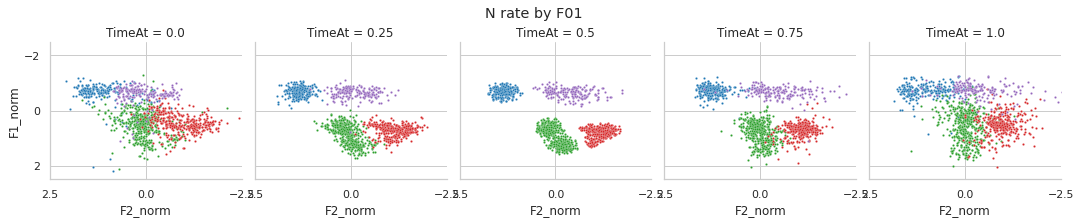

In [33]:
def func2(which_spkr, which_rate):
    with sns.plotting_context('poster', font_scale=0.2):
        sns.set_theme(style='whitegrid')
        g = sns.FacetGrid(data=D.loc[(D.Speaker==which_spkr)&(D.Rate==which_rate)&(D.Vowel.isin(corner_vowels))], 
                          col='TimeAt', col_wrap=num_points, height=3, hue='Vowel', hue_order=custom_vowels, palette=palette)
        g.map(sns.scatterplot, 'F2_norm', 'F1_norm', s=5)
        plt.gca().set_xlim([xm, -xm]);
        plt.gca().set_ylim([ym, -ym]);
        plt.suptitle(f'{which_rate} rate by {which_spkr}', y=1.03);
        plt.gcf().set_facecolor('white')

custom_vowels = ['IY1','EH1','AE1','AA1','UW1']
palette = sns.color_palette("tab10", len(custom_vowels))
xm, ym = 2.5, 2.5

interact(func2, which_spkr=spkr_list, which_rate=['N','F']);
func2('F01','N')

## Vowel duration, space at N and F rate per speaker

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

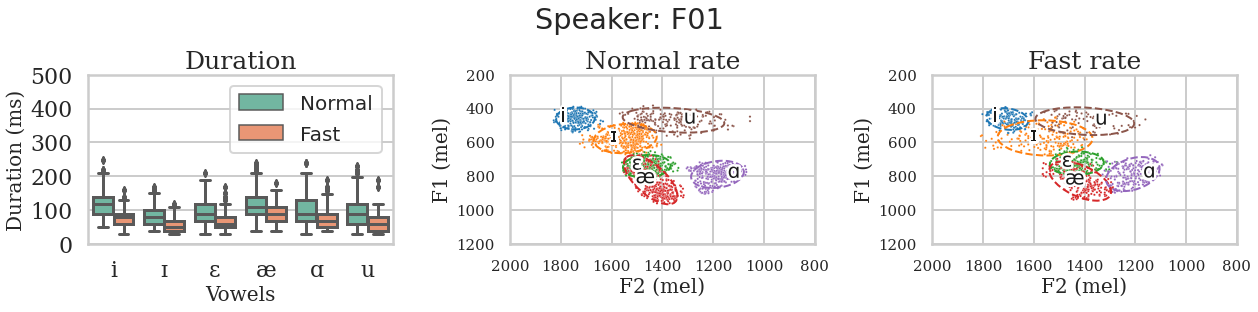

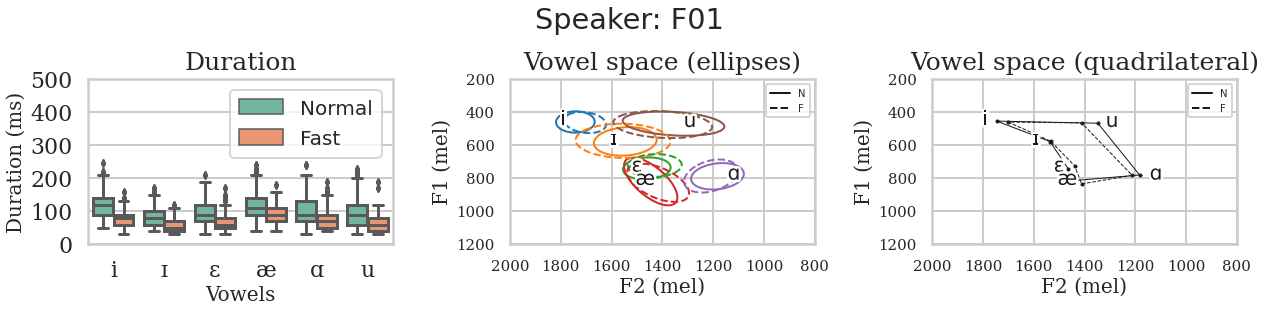

In [34]:
# Check duration plots
def func3(which_spkr):
    file1 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier.png')
    file2 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier_ovoids.png')
    image1 = Image(filename=file1, width=1000)
    image2 = Image(filename=file2, width=1000)
    return display(image1, image2)

interact(func3, which_spkr=spkr_list);
func3('F01')

## Articulatoy data before/after PCA

In [36]:
def _validate_pca_by_reconstruction(df, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, PC, Z):
    pca = PC[which_spkr]['pca']
    scaler = Scaler(which_spkr, Z)
    d = df.loc[(df.Speaker==which_spkr)&(df.Rate==which_rate)&(df.Vowel==which_vowel)&(df.TimeAt==which_time), artic_col]
    dn = df.loc[(df.Speaker==which_spkr)&(df.Rate==which_rate)&(df.Vowel==which_vowel)&(df.TimeAt==which_time), artic_col_norm]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5), facecolor='white')

    # Original data
    plot_palpha(ax1, pal_all[which_spkr], pha=None);
    plot_artic_df(ax1, d, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax1.set_title('Original', fontsize=25)

    # Normalized data
    plot_artic_df(ax2, dn, 
                  tongue_x=['TRx_norm','TBx_norm','TTx_norm'], 
                  tongue_y=['TRz_norm','TBz_norm','TTz_norm'], 
                  jaw_x=['JAWx_norm'], jaw_y=['JAWz_norm'], 
                  lip_x=['ULx_norm','LLx_norm'], lip_y=['ULz_norm','LLz_norm'], 
                  tongue_spline=True, 
                  xlim=(-2.5,2.5), ylim=(-2.5,2.5), # Change to normalized scale
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax2.set_xlim([-2,2])
    ax2.set_ylim([-2,2])
    ax2.set_title('Normalized', fontsize=25)

    # Reconstructed data
    dz = dn.values
    dz = pca.transform(dz)
    dz = pca.inverse_transform(dz)
    dz = scaler.inverse_transform(dz, 'artic')
    dnz = dn.copy()
    dnz[artic_col] = dz
    plot_palpha(ax3, pal_all[which_spkr], pha=None);
    plot_artic_df(ax3, dnz, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax3.set_title('Reconstructed', fontsize=25);
    plt.suptitle(f'{which_spkr} (vowel={which_vowel}, rate={which_rate}, time={which_time})', fontsize=30, y=1.05);
    return fig, (ax1, ax2, ax3)

In [ ]:
which_spkr = 'F01'
which_vowel = 'IY1'
which_rate = 'N'
which_time = 0.5

def func4(which_spkr, which_rate, which_vowel, which_time):
    with sns.plotting_context(context='paper', font_scale=0.8):
        fig, arr = _validate_pca_by_reconstruction(D, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, PC, Z)
        
interact(func4, which_spkr=spkr_list, which_rate=rate_list, which_vowel=vowel_list, which_time=time_list)
func4(which_spkr, which_rate, which_vowel, which_time)

## Comparison between normal and fast rate in articulation based on medians

In [48]:
def _plot_artic_single(df, ax, which_spkr, which_rate, which_vowel, which_time, custom_vowels, 
                      tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=1, show_legend=True, 
                      marker='o', markerfacecolor=True, linestyle='--', tongue_spline=False, **kwargs):
    with sns.plotting_context('paper', font_scale=font_scale, rc=kwargs):
        sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
        ax = plot_palpha(ax, pal_all[which_spkr], pha=None, tickspacing=10)

        colors = sns.color_palette('tab10', len(custom_vowels))
        lines = []
        for which_vowel, color in zip(custom_vowels, colors):
            d = D.loc[(D.Speaker==which_spkr)&(D.Rate==which_rate)&(D.Vowel==which_vowel)&(D.TimeAt==which_time), artic_col]
            d = d.median(axis=0).values
            TNG = d[tongue_idx]
            JAW = d[jaw_idx]
            LIP = d[lip_idx]

            # Draw tongue
            if markerfacecolor:
                ax.plot(TNG[0::2].T, TNG[1::2].T, ls='', marker=marker, ms=3, color=color, zorder=1)
            else:
                ax.plot(TNG[0::2].T, TNG[1::2].T, ls='', marker=marker, ms=3, markerfacecolor=markerfacecolor, color=color, zorder=1)
                
            if tongue_spline:
                f = interpolate.interp1d(TNG[0::2], TNG[1::2], kind='quadratic')
                xnew = np.linspace(TNG[0], TNG[-2], 10, endpoint=True)
                ynew = f(xnew)
                ax.plot(xnew, ynew, linestyle=linestyle, marker='', color=color, zorder=1)
            else:
                ax.plot(TNG[0::2], TNG[1::2], ls=linestyle, marker=marker, ms=3,  color=color, zorder=1)

            # Draw jaw and lips
            if markerfacecolor:
                ax.plot(LIP[0::2], LIP[1::2], ls='None', color=color, marker=marker, ms=3, zorder=1)
                ax.plot(JAW[0::2], JAW[1::2], ls='None', color=color, marker=marker, ms=3, zorder=1, label=vowel2ipa[which_vowel])
            elif markerfacecolor:
                ax.plot(LIP[0::2], LIP[1::2], ls='None', color=color, 
                        marker=marker, ms=3, markerfacecolor=markerfacecolor, zorder=1)
                ax.plot(JAW[0::2], JAW[1::2], ls='None', color=color, 
                        marker=marker, ms=3, markerfacecolor=markerfacecolor, zorder=1, label=vowel2ipa[which_vowel])
            ls, = ax.plot([],[],color=color,marker='o',ms=5)
            lines += [ls]
            
        if show_legend:
            ax.legend(lines, [vowel2ipa[v] for v in custom_vowels])
    return ax

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

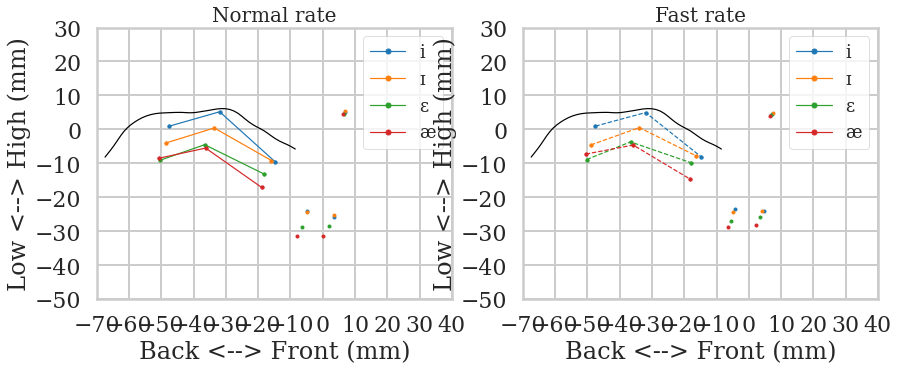

In [50]:
def func5(which_spkr, which_vowel, which_time):
    custom_vowels = ['IY1','IH1','EH1','AE1']

    tongue_idx = [0, 1, 2, 3, 4, 5]
    jaw_idx = [6, 7]
    lip_idx = [8, 9, 10, 11]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), facecolor='white')
    # --- Normal rate
    _plot_artic_single(D, ax1, which_spkr, 'N', which_vowel, which_time, custom_vowels,
                       tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=2, show_legend=True,
                       linestyle='-', marker='o',
                       tongue_spline=False)
    ax1.set_title('Normal rate', fontsize=20)

    # --- Fast rate
    _plot_artic_single(D, ax2, which_spkr, 'F', which_vowel, which_time, custom_vowels,
                       tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=2, show_legend=True,
                       linestyle='--', marker='o', markerfacecolor='None',
                       tongue_spline=False)
    ax2.set_title('Fast rate', fontsize=20)
    
interact(func5, which_spkr=spkr_list, which_vowel=vowel_list, which_time=time_list);
func5('F01', 'IY1', 0.5)